In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from cuml.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import SGDClassifier

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm

# Plotting and Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Language Detection packages
# `langdetect` for detecting language
from langdetect import detect as langdetect_detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# `langid` for an alternative language detection method
from langid import classify as langid_classify

# Text Preprocessing and NLP
# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords

# Tokenizing sentences/words
from nltk.tokenize import word_tokenize

# Part-of-speech tagging
from nltk import pos_tag

# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer
import nltk

# Regular expressions for text pattern matching
import re

# Word Cloud generation
from wordcloud import WordCloud
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

2025-02-21 21:25:46.804938: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-21 21:25:46.958145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740144347.013724  145527 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740144347.030569  145527 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 21:25:47.188489: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import os
import sys
from pathlib import Path

if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("working dir:", workding_dir)

working dir: /home/inflaton/code/CrediNews


In [3]:
from datasets import load_dataset, concatenate_datasets, Dataset

datasets = load_dataset(
    "csv",
    data_files={
        "train": [
            "dataset/train_data_1.csv",
            "dataset/train_data_2.csv",
            "dataset/train_data_3.csv",
            "dataset/train_data_4.csv",
        ],
        "test": "dataset/test_data.csv",
        "rewritten_train": [
            "dataset/rewritten_train_data_1.csv",
            "dataset/rewritten_train_data_2.csv",
            "dataset/rewritten_train_data_3.csv",
            "dataset/rewritten_train_data_4.csv",
        ],
        "rewritten_test": "dataset/rewritten_test_data.csv",
    },
)
datasets

/home/inflaton/miniconda3/envs/fake-news/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
    rewritten_train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    rewritten_test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
})

In [4]:
from cuml.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib  # ✅ For saving/loading the vectorizer


def train_model(train_data, val_data, C=1.0, kernel="linear", gamma="0.001"):
    """Trains an SVM model using TF-IDF vectorization."""

    print(f"\n🚀 Training SVM with C={C}, gamma={gamma}, kernel={kernel}")

    # ✅ Extract texts and labels
    train_texts = train_data["processed_full_content"]
    val_texts = val_data["processed_full_content"]
    y_train = train_data["label"]
    y_val = val_data["label"]

    # ✅ Use TF-IDF instead of CountVectorizer
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(
        val_texts
    )  # ✅ Transform val data with same vectorizer

    # ✅ Train SVM
    model = SVC(kernel=kernel, gamma=gamma, C=C)
    model.fit(X_train, y_train)

    return model

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib


def evaluate_model(model, train_data, val_data):
    """Evaluates the trained SVM model using the stored TF-IDF vectorizer."""
    print("\n📊 Evaluating SVM Model...")

    # ✅ Load saved TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=5000)
    train_texts = train_data["processed_full_content"]
    vectorizer.fit_transform(train_texts)

    # ✅ Transform validation set
    y_val = val_data["label"]
    val_texts = val_data["processed_full_content"]
    X_val = vectorizer.transform(val_texts)

    # ✅ Predict labels
    y_pred = model.predict(X_val)

    # ✅ Compute metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print("\n🏆 Final Evaluation Results:")
    for key, value in {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }.items():
        print(f"🔹 {key.capitalize()}: {value:.4f}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }

In [6]:
train_data = datasets["train"].to_pandas()
val_data = datasets["test"].to_pandas()
data = pd.concat([train_data, val_data], ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60491 entries, 0 to 60490
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   label                   60491 non-null  int64 
 1   full_content            60491 non-null  object
 2   processed_full_content  60491 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [7]:
import joblib

# ✅ Save the trained model
model = joblib.load("results/SVM_model_original.pkl")

print("✅ Model and vectorizer loaded successfully!")

✅ Model and vectorizer loaded successfully!


In [8]:
%%time
perf_original_model_val_data = evaluate_model(model, train_data, val_data)


📊 Evaluating SVM Model...

🏆 Final Evaluation Results:
🔹 Accuracy: 0.9698
🔹 Precision: 0.9642
🔹 Recall: 0.9668
🔹 F1_score: 0.9655
CPU times: user 4.53 s, sys: 92.6 ms, total: 4.62 s
Wall time: 4.8 s


In [9]:
val_data_rewritten = datasets["rewritten_test"].to_pandas()
train_data_rewritten = datasets["rewritten_train"].to_pandas()
data_rewritten = pd.concat(
    [train_data, train_data_rewritten, val_data, val_data_rewritten], ignore_index=True
)
data_rewritten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120982 entries, 0 to 120981
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   label                   120982 non-null  int64 
 1   full_content            120982 non-null  object
 2   processed_full_content  120982 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
%%time

perf_original_model_val_data_rewritten = evaluate_model(
    model, train_data, val_data_rewritten
)


📊 Evaluating SVM Model...

🏆 Final Evaluation Results:
🔹 Accuracy: 0.8661
🔹 Precision: 0.8930
🔹 Recall: 0.7884
🔹 F1_score: 0.8375
CPU times: user 4.66 s, sys: 74.1 ms, total: 4.73 s
Wall time: 4.75 s


In [11]:
%%time

train_data_combined = pd.concat([train_data, train_data_rewritten], ignore_index=True)
val_data_combined = pd.concat([val_data, val_data_rewritten], ignore_index=True)
model_combined = joblib.load("results/SVM_model_combined.pkl")

print("✅ Model and vectorizer loaded successfully!")

✅ Model and vectorizer loaded successfully!
CPU times: user 69.5 ms, sys: 11.5 ms, total: 81 ms
Wall time: 138 ms


In [12]:
perf_combined_model_val_data = evaluate_model(
    model_combined, train_data_combined, val_data
)


📊 Evaluating SVM Model...

🏆 Final Evaluation Results:
🔹 Accuracy: 0.9648
🔹 Precision: 0.9596
🔹 Recall: 0.9600
🔹 F1_score: 0.9598


In [13]:
perf_combined_model_val_data_rewritten = evaluate_model(
    model_combined, train_data_combined, val_data_rewritten
)


📊 Evaluating SVM Model...

🏆 Final Evaluation Results:
🔹 Accuracy: 0.9165
🔹 Precision: 0.9054
🔹 Recall: 0.9037
🔹 F1_score: 0.9045


In [15]:
model_rewritten = joblib.load("results/SVM_model_rewritten.pkl")

print("✅ Model and vectorizer loaded successfully!")

✅ Model and vectorizer loaded successfully!


In [16]:
perf_rewritten_model_val_data = evaluate_model(
    model_rewritten, train_data_rewritten, val_data
)


📊 Evaluating SVM Model...

🏆 Final Evaluation Results:
🔹 Accuracy: 0.9349
🔹 Precision: 0.9672
🔹 Recall: 0.8810
🔹 F1_score: 0.9221


In [17]:
perf_rewritten_model_val_data_rewritten = evaluate_model(
    model_rewritten, train_data_rewritten, val_data_rewritten
)


📊 Evaluating SVM Model...

🏆 Final Evaluation Results:
🔹 Accuracy: 0.9169
🔹 Precision: 0.9107
🔹 Recall: 0.8980
🔹 F1_score: 0.9043


Results saved to results/SVM_metrics.csv


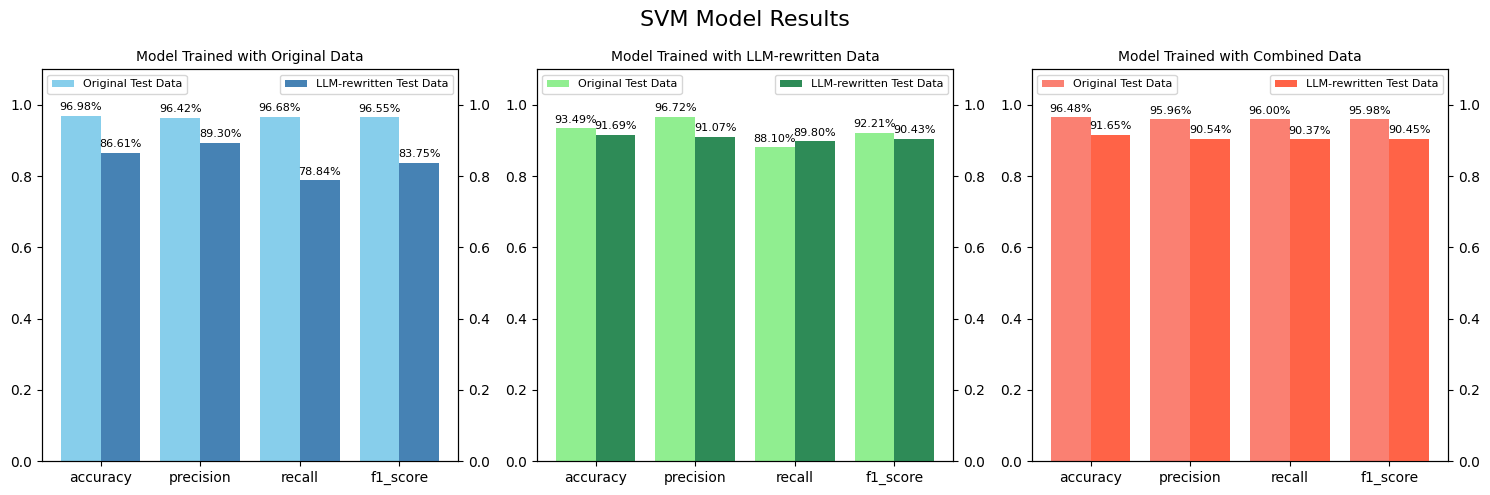

In [19]:
from llm_experiements.utils import *

model = "SVM"
save_results(
    model,
    perf_original_model_val_data,
    perf_original_model_val_data_rewritten,
    perf_combined_model_val_data,
    perf_combined_model_val_data_rewritten,
    perf_rewritten_model_val_data,
    perf_rewritten_model_val_data_rewritten,
)

plot_results(
    model,
    perf_original_model_val_data,
    perf_original_model_val_data_rewritten,
    perf_combined_model_val_data,
    perf_combined_model_val_data_rewritten,
    perf_rewritten_model_val_data,
    perf_rewritten_model_val_data_rewritten,
)